In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

import pyro
from pyro.nn import PyroModule, PyroParam, PyroSample
from pyro import poutine
import pyro.distributions as dist
import pyro.distributions.transforms as T
from torch.optim import Adam

import torch
from torch import tensor, sigmoid
from pyro.distributions import constraints
from torch.distributions.transforms import AffineTransform
import torch.distributions.transforms as TT
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
import torch.nn.init as init
from donuts import compare, DonutsDataset
import os
import sys
from time import sleep
from functools import reduce
import inspect
from operator import itemgetter
from typing import *

pyro.set_rng_seed(1)
is_smoke_test = True
n_samples = 1000
batch_size = 64  # unused
dataset =  DonutsDataset(n_samples=n_samples, hole=None, noise=0.01, factor=0.3)
loader = DataLoader(dataset, batch_size=batch_size)  # unused

In [44]:
from functools import reduce
import sys
from functools import partial

def sumall(tens):
    reified = list(tens)  # FIXME: need the lookahead for initializer
    initializer = torch.zeros_like(reified[0])
    reducer = lambda l, memo: memo + l
    return reduce(reducer, reified, initializer)

def get_logprobs(tr, k):
    site = tr.nodes[k]
    assert site["type"] == "sample" and site["is_observed"], f'{k} is type {site["type"]} and is_observed: {site["is_observed"]}'
    return site["log_prob"]
    
def train(model, dataset=dataset, n_epochs=500, lr=3e-3, n_samples=1000, over_vars=['x1', 'x2']):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    x1, x2 = [dataset.data[x] for x in ['x1', 'x2']]
    dataset.data['x1_x2'] = torch.cat([x1, x2], dim=-1)  # for univariates
    losses = []
    with trange(n_epochs) as epoch_reporter:
        for step in epoch_reporter:
            optimizer.zero_grad()
            cond_model = pyro.condition(model.model, data=dataset.data)
            model_trace = poutine.trace(cond_model).get_trace()
            model_trace.compute_log_prob()
            loss = -sumall(map(partial(get_logprobs, model_trace), over_vars)).mean()
            loss.backward()
            optimizer.step()
            epoch_reporter.set_postfix_str('loss: {:.6f}'.format(loss.detach()))
            model.clear_cache()
    return losses

def visualize(model, dataset=dataset):
    with pyro.plate('samples', 1000):
        x1_flow, x2_flow = model.model()
    compare((x1_flow.detach(), x2_flow.detach(), torch.ones_like(x1_flow)), dataset)

class FlowBased(PyroModule):
    def __init__(self, verbose=True):
        super().__init__()
        self._register_buffers()
        self._build_flow()
 
    def build_flow(self):
        raise NotImplementedError()

    def _build_flow(self):
        
        self.flow_states = []
        before = set(dir(self))
        self.build_flow()
        after = set(dir(self))
        # FIXME: should also add an instance check
        self.flow_states = [getattr(self, new) for new in after - before]
        if len(self.flow_states) == 0:
            print("[WARNING] No flow states registered in self.flow_states after self._build_flow()")

    def register_buffers(self):
        raise NotImplementedError()

    def _register_buffers(self):
        pairs = self.register_buffers()
        for name, tensor in pairs.items():
            assert tensor.requires_grad is not True, f"{name} shouldn't be in autograd"
            self.register_buffer(name, tensor)

    def clear_cache(self):
        for flow in self.flow_states:
            try:
                flow.clear_cache()
            except:
                pass

def smoke_test(model):
    print(model.model())
    with pyro.plate('test', 13):
        x1, x2 = model.model()
        print(x1.shape)
    sleep(0.5)

(tensor(0.2813, grad_fn=<SelectBackward>), tensor(-0.8017, grad_fn=<SelectBackward>))
torch.Size([13])


100%|██████████| 1000/1000 [00:05<00:00, 191.24it/s, loss: 1.172175]


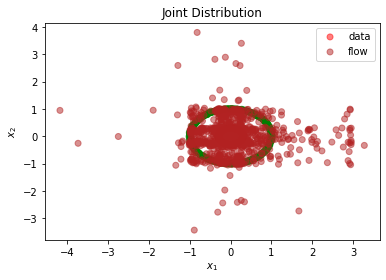

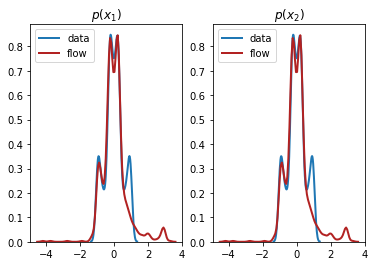

CPU times: user 23.5 s, sys: 416 ms, total: 23.9 s
Wall time: 8.05 s


In [13]:
%%time
class UnivariateModel(FlowBased):
    def __init__(self):
        super().__init__()
        # NOTE: Flows require a stable latent to target. Thus we don't put these on the computation graph.
        self.register_buffer('loc', torch.zeros([2], requires_grad=False))
        self.register_buffer('scale', torch.ones([2], requires_grad=False))

    def build_flow(self):
        self.spline_transform = T.Spline(2, count_bins=16)

    def model(self):
        dist_base = dist.Normal(self.loc, self.scale)
        flow_dist = dist.TransformedDistribution(dist_base, [self.spline_transform])
        xs = pyro.sample('x1_x2', flow_dist.to_event(1))
        # account for batching
        return (xs[:,0], xs[:,1]) if len(xs.shape) == 2 else (xs[0], xs[1])

model = UnivariateModel()
smoke_test(model)

losses = train(model, n_epochs=1 if is_smoke_test else 1000, n_samples=1000, over_vars=['x1_x2'])
visualize(model)

(tensor(-2.3886, grad_fn=<SelectBackward>), tensor(0.0179, grad_fn=<SelectBackward>))
torch.Size([13])


100%|██████████| 1000/1000 [00:11<00:00, 84.78it/s, loss: -0.673555]


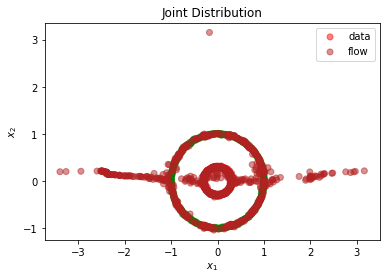

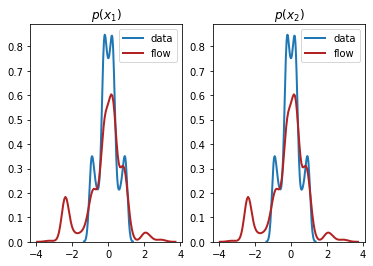

CPU times: user 47.7 s, sys: 608 ms, total: 48.3 s
Wall time: 12.8 s


In [14]:
%%time

class MultivariateModel(FlowBased):
    def __init__(self):
        super().__init__()
        self.register_buffer('loc', torch.zeros([2], requires_grad=False))
        self.register_buffer('scale', torch.ones([2], requires_grad=False))

    def build_flow(self):
        self.spline_transform = T.spline_coupling(2, count_bins=16)

    def model(self):
        dist_base = dist.Normal(self.loc, self.scale)
        flow_dist = dist.TransformedDistribution(dist_base, [self.spline_transform])
        xs = pyro.sample('x1_x2', flow_dist)
        # account for batching
        return (xs[:,0], xs[:,1]) if len(xs.shape) == 2 else (xs[0], xs[1])

model = MultivariateModel()
smoke_test(model)

losses = train(model, n_epochs=1 if is_smoke_test else 1000, n_samples=1000, over_vars=['x1_x2'])
visualize(model)

(tensor([-1.3278], grad_fn=<IndexPutBackward>), tensor([0.2162], grad_fn=<IndexPutBackward>))
torch.Size([13, 1])


100%|██████████| 5000/5000 [00:59<00:00, 83.77it/s, loss: -0.215591]


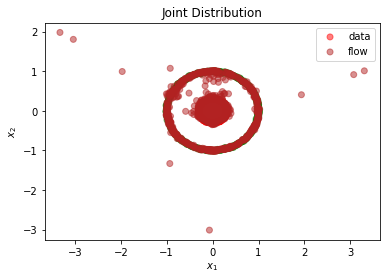

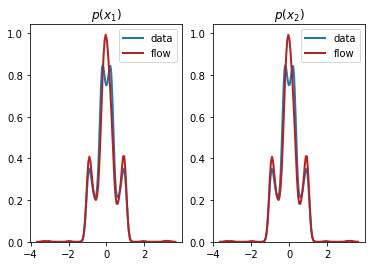

CPU times: user 3min 57s, sys: 3.23 s, total: 4min
Wall time: 1min


In [18]:
%%time
class ConditionalModel(FlowBased):
    def __init__(self):
        super().__init__()
        # NOTE: Flows require a stable latent to target. Thus we don't put these on the computation graph.
        self.register_buffer('loc', torch.zeros([1], requires_grad=False))
        self.register_buffer('scale', torch.ones([1], requires_grad=False))

    def build_flow(self):
        self.x1_transform = T.spline(1)
        self.x2_transform = T.conditional_spline(1, context_dim=1)   # placed in parameters

    def model(self):
        dist_base = dist.Normal(self.loc, self.scale)
        dist_x1 = dist.TransformedDistribution(dist_base, [self.x1_transform])
        dist_x2_given_x1 = dist.ConditionalTransformedDistribution(dist_base, [self.x2_transform])
        x1 = pyro.sample('x1', dist_x1.to_event(1))
        x2 = pyro.sample('x2', dist_x2_given_x1.condition(x1.detach()).to_event(1))
        return x1, x2

model = ConditionalModel()
smoke_test(model)

losses = train(model, n_epochs=(1 if is_smoke_test else 5000), n_samples=1000)
if not is_smoke_test:
    visualize(model)

(tensor([-0.9786], grad_fn=<IndexPutBackward>), tensor([1.9519], grad_fn=<IndexPutBackward>))
torch.Size([13, 1])


100%|██████████| 5000/5000 [01:18<00:00, 63.43it/s, loss: -0.183796]


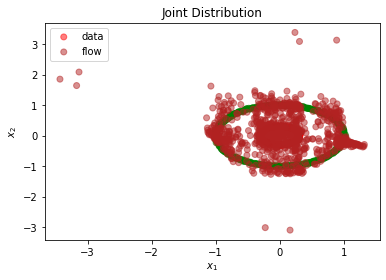

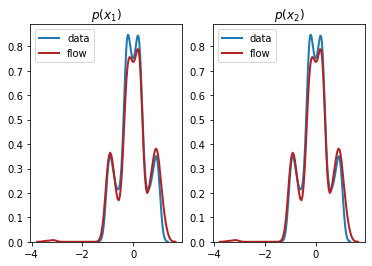

In [36]:
class NoiseModel(FlowBased):
    def __init__(self):
        super().__init__()

    def build_flow(self):
        self.register_buffer('noise_base_loc', torch.zeros([1], requires_grad=False))
        self.register_buffer('noise_base_scale', torch.ones([1], requires_grad=False))
        self.noise_flow_lognorm = AffineTransform(loc=self.noise_base_loc.item(), scale=self.noise_base_scale.item())
        self.x1_transform = T.conditional_spline(1, context_dim=1)
        self.x2_transform = T.conditional_spline(1, context_dim=2)   # placed in parameters

    def model(self):
        noise_base_dist = dist.Normal(self.noise_base_loc, self.noise_base_scale)
        dist_noise = dist.TransformedDistribution(noise_base_dist, [self.noise_flow_lognorm])

        dist_x1_given_noise = dist.ConditionalTransformedDistribution(dist_noise, [self.x1_transform])
        dist_x2_given_noise = dist.ConditionalTransformedDistribution(dist_noise, [self.x2_transform])

        noise = pyro.sample('noise', dist_noise.to_event(1))
        x1 = pyro.sample('x1', dist_x1_given_noise.condition(noise.detach()).to_event(1))
        ctx = torch.cat([noise.detach(), x1.detach()], dim=-1)
        x2 = pyro.sample('x2', dist_x2_given_noise.condition(ctx).to_event(1))
        return x1, x2

model = NoiseModel()
smoke_test(model)

is_smoke_test = False
losses = train(model, n_epochs=(1 if is_smoke_test else 5000), n_samples=1000)
if not is_smoke_test:
    visualize(model)

(tensor([0.6849], grad_fn=<IndexPutBackward>), tensor([1.4137], grad_fn=<IndexPutBackward>))
torch.Size([13, 1])


100%|██████████| 10000/10000 [03:37<00:00, 46.02it/s, loss: -0.574274]


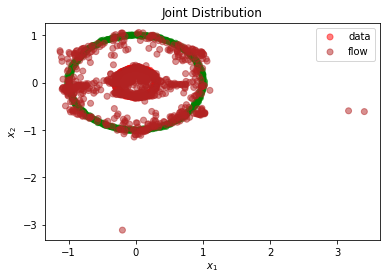

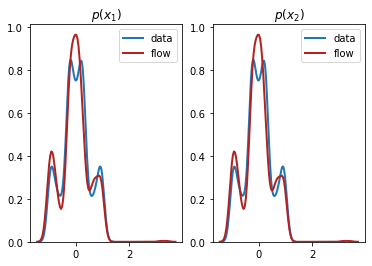

In [43]:
class ContinuousModel(FlowBased):
    def __init__(self):
        super().__init__()

    def register_buffers(self):
        return dict(
            x_base_loc=torch.zeros([1]),      x_base_scale=torch.ones([1]),
            noise_base_loc=torch.zeros([1]),  noise_base_scale=torch.ones([1]),
            factor_base_loc=torch.zeros([1]), factor_base_scale=torch.ones([1]),
        )

    def build_flow(self):
        self.x_flow_lognorm = AffineTransform(loc=self.x_base_loc.item(), scale=self.x_base_scale.item())
        self.noise_flow_lognorm = AffineTransform(loc=self.noise_base_loc.item(), scale=self.noise_base_scale.item())
        self.factor_flow_lognorm = AffineTransform(loc=self.factor_base_loc.item(), scale=self.factor_base_scale.item())

        self.x1_transform = T.conditional_spline(1, context_dim=3, count_bins=16)
        self.x2_transform = T.conditional_spline(1, context_dim=4, count_bins=16)   # placed in parameters

    def model(self):
        x_base_dist = dist.Normal(self.noise_base_loc, self.x_base_scale)
        dist_x = dist.TransformedDistribution(x_base_dist, [self.x_flow_lognorm])

        noise_base_dist = dist.Normal(self.noise_base_loc, self.noise_base_scale)
        dist_noise = dist.TransformedDistribution(noise_base_dist, [self.noise_flow_lognorm])

        factor_base_dist = dist.Normal(self.factor_base_loc, self.factor_base_scale)
        dist_factor = dist.TransformedDistribution(factor_base_dist, [self.factor_flow_lognorm])

        cond_dist_x1 = dist.ConditionalTransformedDistribution(dist_x, [self.x1_transform])
        cond_dist_x2 = dist.ConditionalTransformedDistribution(dist_x, [self.x2_transform])

        noise = pyro.sample('noise', dist_noise.to_event(1))
        factor = pyro.sample('factor', dist_factor.to_event(1))
        ctx1 = torch.cat([noise.detach(), factor.detach()], dim=-1)
        x1 = pyro.sample('x1', cond_dist_x1.condition(ctx1).to_event(1))

        ctx2 = torch.cat([ctx1.detach(), x1.detach()], dim=-1)
        x2 = pyro.sample('x2', cond_dist_x2.condition(ctx2).to_event(1))
        return x1, x2

model = NoiseModel()
smoke_test(model)

is_smoke_test = False
losses = train(model, n_epochs=(1 if is_smoke_test else 10000), n_samples=1000)
if not is_smoke_test:
    visualize(model)